In [39]:
import os
import argparse
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
    )
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten,
    Activation,
    )
import pickle
import setGPU
import json

import matplotlib.pyplot as plt

from tensorflow import keras
import sys
import keras_dgl
from keras_dgl.layers import GraphAttentionCNN,MultiGraphCNN,MultiGraphAttentionCNN
import sys
sys.path.append(os.path.abspath(os.path.join('/eos/home-n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/L1regression/')))
import utils.data_processing as data_proc
from importlib import reload 
reload(data_proc)

import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Activation, Dropout,Lambda
from tensorflow.keras.models import Model, Sequential
import nn.models as nn_models
reload(nn_models)

import nn.losses as nn_losses
reload(nn_losses)

import keras_tuner
import tensorflow.keras.backend as K


In [3]:
data_file = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/L1regression/output/l1_regression_train_selective.h5'
with h5py.File(data_file,'r') as open_file :
    reco_data = np.array(open_file['smeared_data'])
    reco_met = np.array(open_file['smeared_met'])
    reco_ht = np.array(open_file['smeared_ht'])
    true_data = np.array(open_file['true_data'])
    true_met = np.array(open_file['true_met'])
    true_ht = np.array(open_file['true_ht'])
    ids = np.array(open_file['ids'])
    ids_names = np.array(open_file['ids_names'])

In [4]:
graph_data = data_proc.GraphCreator(reco_data,reco_met,reco_ht, true_met,true_ht,ids,log_features=['pt'])


In [5]:
num_filters = 1
graph_conv_filters = graph_data.adjacency
graph_conv_filters = K.constant(graph_conv_filters)


In [6]:
batch_size = 1024
loss_function = nn_losses.get_loss_func('huber_1.0')
metric_thresholds = [0,50,100]
metrics = [nn_losses.MseThesholdMetric(threshold=t) for t in metric_thresholds]
num_filters=1
graph_conv_filters = graph_data.adjacency
graph_conv_filters = K.constant(graph_conv_filters)
hp = keras_tuner.HyperParameters()
hypermodel = nn_models.GraphAttentionHyperModel(features_input_shape=(graph_data.features.shape[1],graph_data.features.shape[2]), 
                                        adjancency_input_shape=(graph_data.adjacency.shape[1],graph_data.adjacency.shape[2]),
                                        filters_input_shape=(graph_conv_filters.shape[1],graph_conv_filters.shape[2]), 
                                        num_filters=num_filters, 
                                        loss_function=loss_function,
                                        metrics=metrics)

workdir = "/eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/L1regression/output2/"
tuner = keras_tuner.Hyperband(hypermodel = hypermodel,
                     objective = keras_tuner.Objective("val_loss", direction="min"),
                    executions_per_trial=1,
                    max_epochs=50,
                    overwrite=False,
                     directory=workdir,
                     project_name='hyperband_tuner')




INFO:tensorflow:Reloading Oracle from existing project /eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/L1regression/output2/hyperband_tuner/oracle.json
INFO:tensorflow:Reloading Tuner from /eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/L1regression/output2/hyperband_tuner/tuner0.json


In [7]:
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.get_best_models(num_models=1)[0]


In [71]:
callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-9),
]
model = tuner.hypermodel.build(best_hps)
history = model.fit([graph_data.features, graph_data.adjacency,graph_conv_filters],graph_data.labels,
             validation_split=0.2,
             epochs=10,
             batch_size=1024,
             shuffle=True,
             callbacks=callbacks,
             use_multiprocessing=True,
             workers=3)

Epoch 1/10
45/45 [==============================] - 5s 53ms/step - loss: 52.3077 - MseThesholdMetric_0: 184.0643 - MseThesholdMetric_50: 229.1595 - MseThesholdMetric_100: 341.9376 - val_loss: 51.5189 - val_MseThesholdMetric_0: 641.3297 - val_MseThesholdMetric_50: 821.5171 - val_MseThesholdMetric_100: 1225.8251 - lr: 0.0100
Epoch 2/10
45/45 [==============================] - 2s 38ms/step - loss: 51.5845 - MseThesholdMetric_0: 54.8939 - MseThesholdMetric_50: 68.3761 - MseThesholdMetric_100: 100.9546 - val_loss: 51.1954 - val_MseThesholdMetric_0: 76.0850 - val_MseThesholdMetric_50: 93.5216 - val_MseThesholdMetric_100: 134.4711 - lr: 0.0100
Epoch 3/10
45/45 [==============================] - 2s 36ms/step - loss: 51.4300 - MseThesholdMetric_0: 20.2506 - MseThesholdMetric_50: 22.9262 - MseThesholdMetric_100: 30.8389 - val_loss: 51.1255 - val_MseThesholdMetric_0: 21.7966 - val_MseThesholdMetric_50: 24.9857 - val_MseThesholdMetric_100: 33.7775 - lr: 0.0100
Epoch 4/10
45/45 [===================

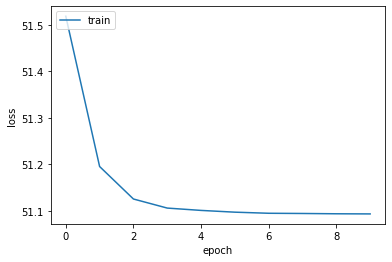

In [72]:
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
dnn_correction = model.predict([graph_data.features, graph_data.adjacency,graph_conv_filters],batch_size=1024)

In [9]:
loss = model.evaluate([graph_data.features, graph_data.adjacency,graph_conv_filters],batch_size=1024)

57/57 [==============================] - 0s 975us/step - loss: 7.9942e-04 - MseThesholdMetric_0: nan - MseThesholdMetric_50: nan - MseThesholdMetric_100: nan


In [40]:
reload(data_proc)
evaluator = data_proc.MetResolutionEvaluator(graph_data.reco_met,graph_data.true_met,graph_data.process_ids,dnn_correction,mask=None)


[]

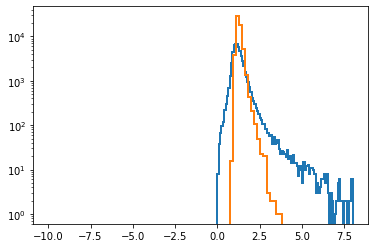

In [45]:
_, bins,_ = plt.hist(graph_data.labels[:,0],bins=np.linspace(0,8,100),histtype='step',linewidth=2,label='Baseline')
_, bins,_ = plt.hist(dnn_correction,bins=np.linspace(-10,8,100),histtype='step',linewidth=2,label='Corrected')
plt.semilogy()


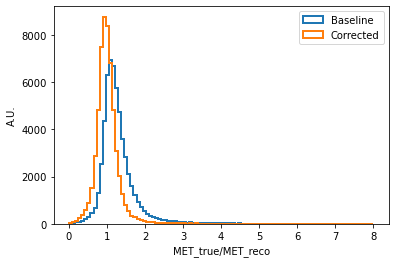

In [46]:
_, bins,_ = plt.hist(evaluator.met_ratio,bins=np.linspace(0,8,100),histtype='step',linewidth=2,label='Baseline')
_ = plt.hist(evaluator.met_ratio_corr,bins=bins,histtype='step',linewidth=2,label='Corrected')
#plt.semilogy()
plt.xlabel('MET_true/MET_reco')
plt.ylabel('A.U.')
plt.legend()


In [16]:
def compute_resolution(x, y, nbin,log_bins_x=True):
    """
    Returns the center of bins array, the mean of y for each bin and stand.dev.
    https://vmascagn.web.cern.ch/LABO_2020/profile_plot.html
    """
    # use of the 2d hist by numpy to avoid plotting
    if log_bins_x :
        nbin_x = np.logspace(0,3,nbin)
        nbin_y = np.linspace(-1,1,nbin)
        bins = [nbin_x,nbin_y]
    else :
        bins=nbin
    h, xe, ye = np.histogram2d(x,y,bins)

    # bin width
    xbinw = xe[1]-xe[0]

    x_array      = []
    x_slice_mean = []
    x_slice_mpv = []
    x_slice_res  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            ye_slice,xe_slice = np.histogram(yvals, bins=np.linspace(0,3,100))
            xe_slice_centers = (xe_slice[:-1]+xe_slice[1:])/2
            x_slice_mpv.append(xe_slice[int(np.argmax(ye_slice))])
            x_slice_res.append( (np.quantile(yvals,0.84)-np.quantile(yvals,0.16))/2.)
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_res = np.array(x_slice_res)
    x_slice_mpv = np.array(x_slice_mpv)

    return x_array, x_slice_mean,x_slice_mpv, x_slice_res


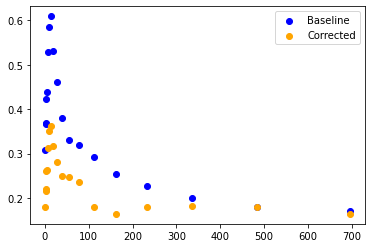

In [47]:
p_x, p_mean, p_mpv, p_res = compute_resolution(evaluator.true_met,evaluator.met_ratio,nbin=20)
plt.scatter(p_x, p_res,marker='o',color='blue',label='Baseline')

p_x, p_mean,p_mpv, p_res = compute_resolution(evaluator.true_met,evaluator.met_ratio_corr,nbin=20)
plt.scatter(p_x, p_res,marker='o',color='orange',label='Corrected')
#plt.xlabel(x_title)
#plt.ylabel(y_title)
#plt.ylim(0,1)
plt.legend()


In [27]:
import ROOT

def makeEffHist(name, refArr, corrArr, corrThr, xmax,nbins=20):
    not_matched = []
    eff_bins = np.linspace(0,xmax,nbins+1)
    ret = ROOT.TEfficiency(name+"_eff","",nbins,eff_bins)
    for i in range(0,len(refArr)):
        ret.Fill(corrArr[i]>corrThr,refArr[i])
    ret.SetStatisticOption(ret.kFCP)        
    return ret,eff_bins 

def calculateEff(name, refArr, corrArr, corrThr, xmax,nbins=20):
    ret,eff_bins = makeEffHist(name, refArr, corrArr, corrThr, xmax,nbins)
    eff_bins_centers = (eff_bins[1:]+eff_bins[:-1])/2.
    eff_bins_err = eff_bins_centers-eff_bins[:-1]
    yvals, yvals_up, yvals_down = [],[],[]
    for i in range(len(eff_bins_centers)):
        yvals.append(ret.GetEfficiency(i+1))
        yvals_up.append(ret.GetEfficiencyErrorUp(i+1))
        yvals_down.append(ret.GetEfficiencyErrorLow(i+1))
    return eff_bins_centers,eff_bins_err,np.array(yvals),np.vstack( (np.array(yvals_down),np.array(yvals_up)))
        
    


Welcome to JupyROOT 6.26/04


/tmp/nchernya/ipykernel_17378/4197582734.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ret.Fill(corrArr[i]>corrThr,refArr[i])


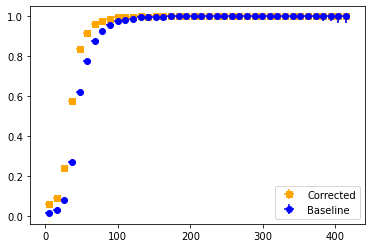

In [49]:
eff_corr_bins,eff_corr_bin_err,eff_corr,eff_corr_err = calculateEff('corr',evaluator.true_met,evaluator.corr_met,40,420,nbins=40)
eff_bins,eff_bin_err,eff,eff_err = calculateEff('reco',evaluator.true_met,evaluator.reco_met,40,420,nbins=40)


_ = plt.errorbar(eff_corr_bins,eff_corr,yerr=eff_corr_err,xerr=eff_corr_bin_err, color='orange',marker='s',linestyle='',label='Corrected')
_ = plt.errorbar(eff_bins,eff,yerr=eff_err,xerr=eff_bin_err, color='b',marker='o',linestyle='',label='Baseline')
plt.legend()


In [50]:
def makeRatePlot(refArr, corrThr):
    #indecies = np.where(refArr>thresh]
    eff = [np.sum(refArr>thresh)/len(refArr) for thresh in corrThr]
    return eff

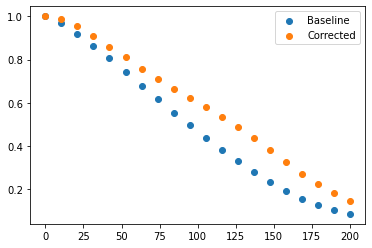

In [52]:
corrThr = np.linspace(0,200,20)
eff = makeRatePlot(evaluator.reco_met,corrThr)
eff_corr = makeRatePlot(evaluator.corr_met,corrThr)
_ = plt.scatter(corrThr,eff,label='Baseline')
_ = plt.scatter(corrThr,eff_corr,label='Corrected')

#plt.semilogy()
plt.legend()


In [56]:
mask_qcd = np.where(ids==1)
mask_w = np.where(ids==0)
evaluator_qcd = data_proc.MetResolutionEvaluator(graph_data.reco_met,graph_data.true_met,
                                                 graph_data.process_ids,dnn_correction,mask=mask_qcd)
evaluator_w = data_proc.MetResolutionEvaluator(graph_data.reco_met,graph_data.true_met,
                                                 graph_data.process_ids,dnn_correction,mask=mask_w)

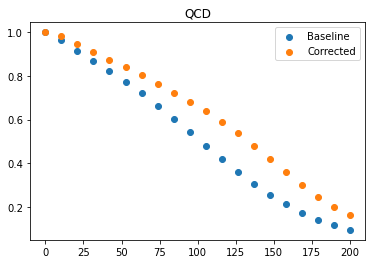

In [62]:
corrThr = np.linspace(0,200,20)
eff = makeRatePlot(evaluator_qcd.reco_met,corrThr)
eff_corr = makeRatePlot(evaluator_qcd.corr_met,corrThr)
_ = plt.scatter(corrThr,eff,label='Baseline')
_ = plt.scatter(corrThr,eff_corr,label='Corrected')
plt.title('QCD')
#plt.semilogy()
plt.legend()

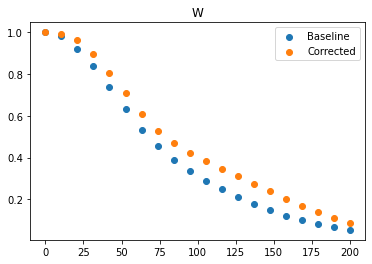

In [59]:
corrThr = np.linspace(0,200,20)
eff = makeRatePlot(evaluator_w.reco_met,corrThr)
eff_corr = makeRatePlot(evaluator_w.corr_met,corrThr)
_ = plt.scatter(corrThr,eff,label='Baseline')
_ = plt.scatter(corrThr,eff_corr,label='Corrected')
plt.title('W')
#plt.semilogy()
plt.legend()

/tmp/nchernya/ipykernel_17378/4197582734.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ret.Fill(corrArr[i]>corrThr,refArr[i])


Text(0.5, 1.0, 'W')

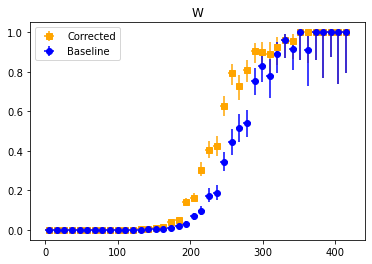

In [76]:
thresh = 220
eff_corr_bins,eff_corr_bin_err,eff_corr,eff_corr_err = calculateEff('corr',evaluator_w.true_met,evaluator_w.corr_met,thresh,420,nbins=40)
eff_bins,eff_bin_err,eff,eff_err = calculateEff('reco',evaluator_w.true_met,evaluator_w.reco_met,thresh,420,nbins=40)


_ = plt.errorbar(eff_corr_bins,eff_corr,yerr=eff_corr_err,xerr=eff_corr_bin_err, color='orange',marker='s',linestyle='',label='Corrected')
_ = plt.errorbar(eff_bins,eff,yerr=eff_err,xerr=eff_bin_err, color='b',marker='o',linestyle='',label='Baseline')
plt.legend()
plt.title('W')


/tmp/nchernya/ipykernel_17378/4197582734.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ret.Fill(corrArr[i]>corrThr,refArr[i])


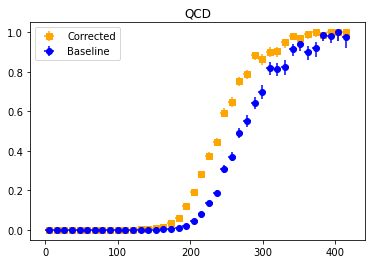

In [77]:
eff_corr_bins,eff_corr_bin_err,eff_corr,eff_corr_err = calculateEff('corr',evaluator_qcd.true_met,evaluator_qcd.corr_met,thresh,420,nbins=40)
eff_bins,eff_bin_err,eff,eff_err = calculateEff('reco',evaluator_qcd.true_met,evaluator_qcd.reco_met,thresh,420,nbins=40)


_ = plt.errorbar(eff_corr_bins,eff_corr,yerr=eff_corr_err,xerr=eff_corr_bin_err, color='orange',marker='s',linestyle='',label='Corrected')
_ = plt.errorbar(eff_bins,eff,yerr=eff_err,xerr=eff_bin_err, color='b',marker='o',linestyle='',label='Baseline')
plt.title('QCD')
plt.legend()